# Actividad 3.1 - Detección de Peatones con SVM
## Navegación autónoma (Gpo 10)
## Alumnos:

In [199]:
#from google.colab import drive
#drive.mount('/content/drive')

In [200]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [201]:
# Función para cargar imágenes desde una carpeta
def cargar_imagenes_desde_carpeta(carpeta):
    imagenes = []
    for nombre_archivo in os.listdir(carpeta):
        img = cv2.imread(os.path.join(carpeta, nombre_archivo), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            imagenes.append(img)
    return imagenes

In [202]:
# Función para extraer características HOG
def extraer_caracteristicas_hog(imagenes):
    caracteristicas = []
    for imagen in imagenes:
        fd = hog(imagen, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), block_norm='L2-Hys')
        caracteristicas.append(fd)
    return np.array(caracteristicas)

In [203]:

# Rutas a los directorios
#base_dir = '/content/drive/MyDrive/Navegacion_autonoma/ECI-DATCOM-UGR_Deteccion_peatones-master/data'
base_dir = './data'
carpeta_entrenamiento_peatones = os.path.join(base_dir, 'train/pedestrians')
carpeta_entrenamiento_fondo = os.path.join(base_dir, 'train/background')
carpeta_prueba_peatones = os.path.join(base_dir, 'test/pedestrians')
carpeta_prueba_fondo = os.path.join(base_dir, 'test/background')

# Cargar imágenes de entrenamiento y prueba
imagenes_entrenamiento_positivas = cargar_imagenes_desde_carpeta(carpeta_entrenamiento_peatones)
imagenes_entrenamiento_negativas = cargar_imagenes_desde_carpeta(carpeta_entrenamiento_fondo)
imagenes_prueba_positivas = cargar_imagenes_desde_carpeta(carpeta_prueba_peatones)
imagenes_prueba_negativas = cargar_imagenes_desde_carpeta(carpeta_prueba_fondo)






In [ ]:
# Imprimir la cantidad de imágenes cargadas
print(f"Imágenes de entrenamiento positivas: {len(imagenes_entrenamiento_positivas)}")
print(f"Imágenes de entrenamiento negativas: {len(imagenes_entrenamiento_negativas)}")
print(f"Imágenes de prueba positivas: {len(imagenes_prueba_positivas)}")
print(f"Imágenes de prueba negativas: {len(imagenes_prueba_negativas)}")


In [205]:
# Etiquetas (1 para peatones, 0 para fondo)
etiquetas_entrenamiento_positivas = [1] * len(imagenes_entrenamiento_positivas)
etiquetas_entrenamiento_negativas = [0] * len(imagenes_entrenamiento_negativas)
etiquetas_prueba_positivas = [1] * len(imagenes_prueba_positivas)
etiquetas_prueba_negativas = [0] * len(imagenes_prueba_negativas)

# Combinar imágenes y etiquetas de entrenamiento y prueba
imagenes_entrenamiento = imagenes_entrenamiento_positivas + imagenes_entrenamiento_negativas
etiquetas_entrenamiento = etiquetas_entrenamiento_positivas + etiquetas_entrenamiento_negativas
imagenes_prueba = imagenes_prueba_positivas + imagenes_prueba_negativas
etiquetas_prueba = etiquetas_prueba_positivas + etiquetas_prueba_negativas


In [206]:
# Extraer características HOG
caracteristicas_entrenamiento = extraer_caracteristicas_hog(imagenes_entrenamiento)
caracteristicas_prueba = extraer_caracteristicas_hog(imagenes_prueba)

# Entrenar el modelo SVM
modelo_svm = LinearSVC()

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [False],  # Cambiar dual=True a dual=False
    'multi_class': ['ovr', 'crammer_singer'],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(estimator=modelo_svm, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(caracteristicas_entrenamiento, etiquetas_entrenamiento)

modelo_svm = LinearSVC(grid_search.best_params_)

modelo_svm.fit(caracteristicas_entrenamiento, etiquetas_entrenamiento)

# Predecir en el conjunto de prueba
predicciones_prueba = modelo_svm.predict(caracteristicas_prueba)

# Evaluar el modelo
exactitud = accuracy_score(etiquetas_prueba, predicciones_prueba)
precision = precision_score(etiquetas_prueba, predicciones_prueba)
recall = recall_score(etiquetas_prueba, predicciones_prueba)
f1 = f1_score(etiquetas_prueba, predicciones_prueba)
matriz_confusion = confusion_matrix(etiquetas_prueba, predicciones_prueba)

print(f"Exactitud: {exactitud * 100:.2f}%")
print(f"Precisión: {precision * 100:.2f}%")
print(f"Sensibilidad (Recall): {recall * 100:.2f}%")
print(f"Puntuación F1: {f1 * 100:.2f}%")
print("Matriz de confusión:")
print(matriz_confusion)

Exactitud: 96.00%
Precisión: 96.53%
Sensibilidad (Recall): 94.60%
Puntuación F1: 95.56%
Matriz de confusión:
[[583  17]
 [ 27 473]]


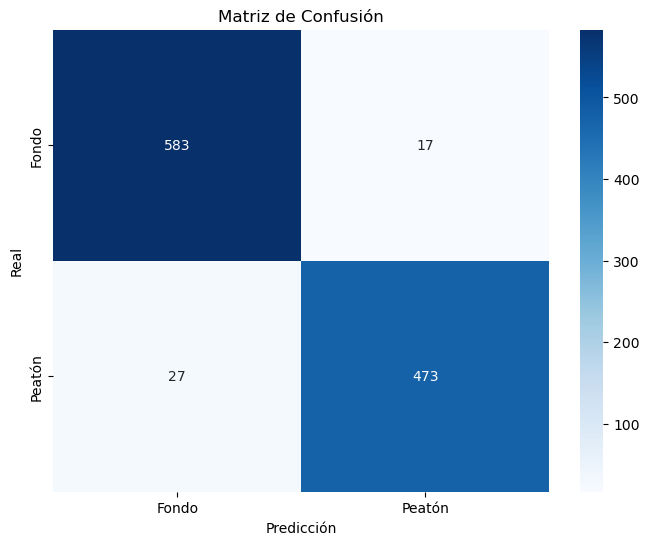

In [208]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Fondo', 'Peatón'], yticklabels=['Fondo', 'Peatón'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()